In [1]:
# Import packages
import io
import math 
import os
from glob import glob
import earthpy as et
import earthaccess
import pathlib
import geopandas as gpd
import hvplot.xarray  
import hvplot.pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import requests
import xarray as xr
import zipfile
import xrspatial
from xrspatial import aspect
from xrspatial import slope
import warnings
warnings.filterwarnings('ignore')

c:\Users\anpo9052\AppData\Local\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Modeling Habitat Suitability of *Sorghastrum nutans*

### Project Description
*Sorghastrum nutans* (Indiangrass) is a common, perennial grass native to North America, found from the east coast to the Rocky mountains (Brakie, 2017). It can grow from 3 to 8 feet, and is suitable for livestock grazing (Brakie, 2017). However, this grass can be invasive in some regions and displace more desirable vegetation if not properly managed (Brakie, 2017). In the past 50 years its range has progressively moved northward (GBIF, 2024), potentially due to shifts in climatic conditions. To understand future projections of habitat suitability for this grass, this project analyzes multiple data layers related to soil, topography and climate. 

In this notebook, I analyze the habitat suitability of *S. nutans* in two Colorado National Grasslands (Pawnee and Comanche) 50 and 75 years into the future under "business as usual" Representative Concentration Pathway (RCP) 8.5 precipitation projections, as well as current data on elevation, slope, and soil pH. 

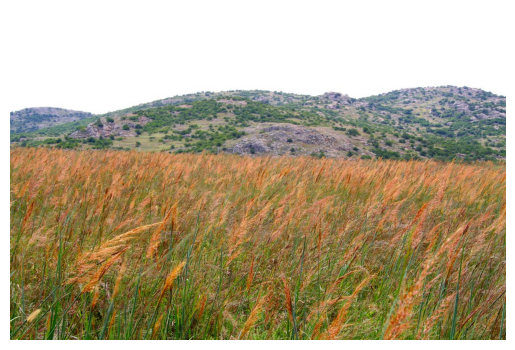

In [2]:
img_grass = mpimg.imread('img/indiangrass.jpg')
imgplot = plt.imshow(img_grass)
plt.axis('off')
plt.show()

The image above depicts a field of *S. nutans*. Photo credit: [Flickr amy_buthod](https://www.flickr.com/photos/akbuthod/1392659246)

### Site Descriptions

Both National grasslands selected for this project are found in Colorado, and were historically inhabited by Native Americans until the 1800s when settlers forcibly displaced them (Maxwell, 2020). Drought during the dust bowl in addition to settlers poor agricultural practices resulted in most settlers leaving these areas, and the government purchasing the land, restoring the soil, and classifying both areas as National Grasslands in 1960 (Maxwell, 2020).

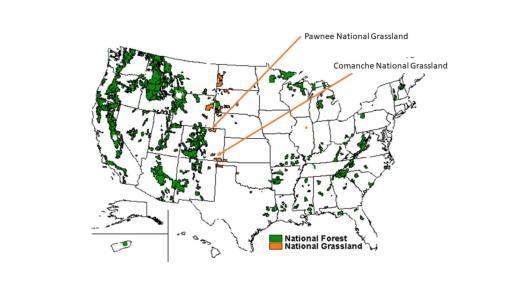

In [3]:
img_map = mpimg.imread('img/map_grasslands.jpg')
imgplot = plt.imshow(img_map)
plt.axis('off')
plt.show()

#### Comanche National Grassland 

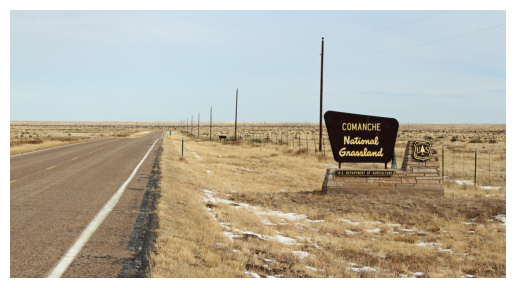

In [4]:
img_comanche = mpimg.imread('img/comanche.jpg')
imgplot = plt.imshow(img_comanche)
plt.axis('off')
plt.show()

Comanche National Grassland is located on the southeastern edge of Colorado (US Forest Service). It spans over 440,000 acres of discontinuous grassland, due to some interspersed areas being privately owned (US Forest Service). 

Photo Credit: Jeffrey Beall

### Pawnee National Grassland

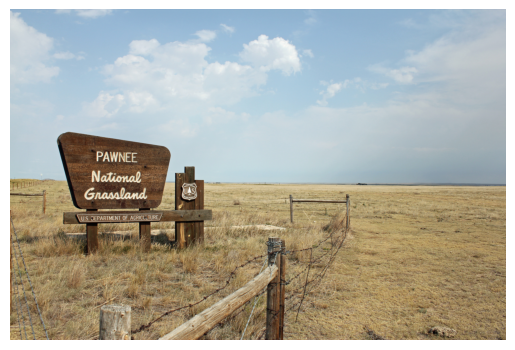

In [5]:
img_pawnee = mpimg.imread('img/pawnee.jpg')
imgplot = plt.imshow(img_pawnee)
plt.axis('off')
plt.show()

Pawnee national grassland is located in Weld County, Colorado, which is in the northern part of the state. It is contained within a 30-by-60 mile area and spans over 190,000 acres (US Forest Service). Similarly to Comanche, Pawnee also is a checkerboard of private and public land (US Forest Service). Pawnee is also renowned for being a great birding spot for a number of migrating species. 

Photo credit: Jeffrey Beall

### Data description
The following data is downloaded, harmonized, and analyzed in this notebook:

**Grassland data**: Shape files of each of the two grasslands were obtained from the United States Forest Service. 

**Soil pH data**: obtained from Duke University, POLARIS. pH of soil (log scale) was downloaded at 60 to 100 cm depth for each grassland with a 30m spatial resolution; data arrays were merged and clipped to the grassland boundaries. 

**Elevation data**: downloaded from the NASA Shuttle Radar Topography Mission (SRTM) at a 30m spatial resolution for the entire extent of both grasslands and then clipped to the boundaries separately. Elevation data was then used to calculate slope within the grasslands. 

**Precipitation data**: downloaded from Northwest Knowledge Network MACAv2. Monthly precipitation data was downloaded from the CCSM4 climate model for the date ranges of 2071-2075 and 2096-2099 under the RCP 8.5. The monthly values were summed for each year and the total precipitation values for 2074 and 2099 were extracted to analyze the habitat suitability in 50 and 75 years. 

### Creating data directories

In [6]:
data_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'final-project')
boundaries_dir = os.path.join(data_dir, 'boundaries')
polaris_dir = os.path.join(data_dir, 'polaris')
elevation_dir = os.path.join(data_dir, 'elevation')
precipitation_dir = os.path.join(data_dir, 'precipitation')

for dir in [data_dir, boundaries_dir, polaris_dir, precipitation_dir, elevation_dir]:
    """
    Create directories if they don't exist
    """
    if not os.path.exists(dir):
        os.makedirs(dir)

# Define utm zone
utm = 32613

## Dowloading Data for Pawnee and Comanche National Grasslands

### Data Citation:
United States Forest Service (USFS). (2023). U.S. National Grassland Shapefiles [Data set]. USFS Enterprise Data Warehouse. Accessed 2024-11-20 from https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip

In [7]:
# Define the download URL for the study area
usfs_grassland_url = (
    'https://data.fs.usda.gov/geodata/edw'
    '/edw_resources/shp/S_USA.NationalGrassland.zip'
)
# Check the URL is correct
try:
    grass_shapefile = os.path.join(
        boundaries_dir, 'grasslands.shp')
    if not os.listdir(boundaries_dir):
        gdf = gpd.read_file(usfs_grassland_url)
        gdf.to_file(grass_shapefile)
    else:
        gdf = gpd.read_file(grass_shapefile)
except URLError as e:
    print(f"Failed to open URL: {e.reason}")

In [8]:
# Select the two study areas and look at it
selectedgrass_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                     'Pawnee National Grassland',
                  ]])
selectedgrass_gdf

,NATIONALGR,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
GRASSLANDN,,,,,
Comanche National Grassland,295522010328,444413.904,0.183064,26.658022,"MULTIPOLYGON (((-104.02263 37.69224, -104.0225..."
Pawnee National Grassland,295523010328,208424.885,0.089972,15.341594,"MULTIPOLYGON (((-104.58106 40.82664, -104.5810..."


Text(0.5, 1.0, 'National Grasslands of Colorado')

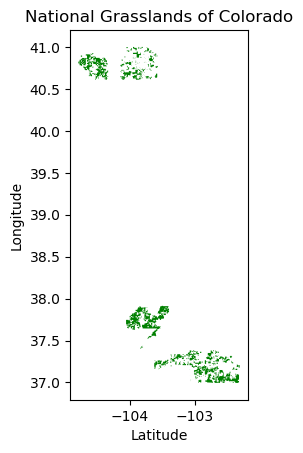

In [9]:
# Make a quick plot to check data
selectedgrass_gdf.plot(color='green')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("National Grasslands of Colorado")

Text(0.5, 1.0, 'Pawnee National Grasslands')

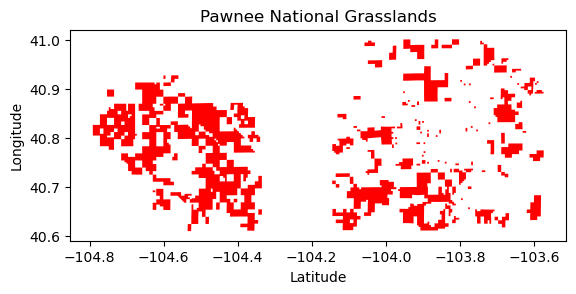

In [10]:
# Map of Pawnee
Pawnee_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[ 
                     'Pawnee National Grassland',
                  ]])
Pawnee_gdf.plot(color='red') 
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Pawnee National Grasslands")

Text(0.5, 1.0, 'Comanche National Grasslands')

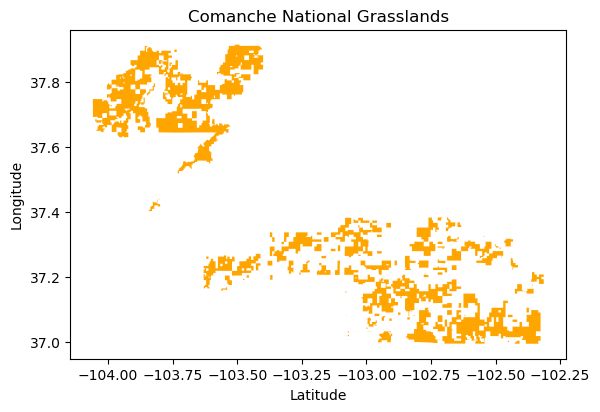

In [11]:
# Map of Comanche
Comanche_gdf = (gdf.set_index('GRASSLANDN')
               .loc[[
                     'Comanche National Grassland', 
                  ]])
Comanche_gdf.plot(color="orange") 
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Comanche National Grasslands")

## Downloading soil pH data

### Data Citation:
Duke University. (2019). POLARIS Soil Properties v1.0: pH Mean 60-100 cm Depth [Data set]. Duke University Hydrology Laboratory. Accessed 2024-11-20 from http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/

The following function to download POLARIS data was adapted from [pth6570](https://github.com/pth6570/earth-analytics-intro-final/blob/main/final_project_data_analysis.ipynb)

In [12]:
def get_polaris_data(data_directory, input_gdf, index_col_name):
    """
    This function downloads Polaris soil data for the extent of each
    row in a geodataframe and creates a merged data array for each.
    Downloaded data is saved in individual folders for each row. Merged
    data arrays for each row are saved in "Merged_files" subfolder.

    Paramters
    ----------
    data_directory : path
        The path to the data directory. A sub-directory will be created
        within this directory for the soil data downloads.

    input_gdf: geopandas.GeoDataFrame
        A geodataframe that contains the areas of interest. Polaris soil
        data will be downloaded according to the bounds of each row in
        the dataframe.

    index_col_name: string
        A string containing the name of the geoDataFrame column that
        should be used as the index. This index will be used to name
        output files.

    Returns
    ----------
    output_lst: list of data arrays
        Returns a list of data arrays representing the merged Polaris
        tif data for each row in the input geodataframe
    """

    # Set index to specified index column
    input_gdf = input_gdf.reset_index().set_index(index_col_name)

    # Create dataframe of bounds of each gdf row
    bound_pd = pd.concat([input_gdf.bounds], axis=1)

    file_list = []
    # Loop through each row in the boundary dataframe
    for ind in bound_pd.index:
        print("\n", ind, ":")
        # Define and round min and max longitude and latitudes
        min_lon = math.floor(bound_pd["minx"][ind])
        max_lon = math.ceil(bound_pd["maxx"][ind])
        min_lat = math.floor(bound_pd["miny"][ind])
        max_lat = math.ceil(bound_pd["maxy"][ind])
        # Define range
        lat_range = range(min_lat, max_lat)
        lon_range = range(min_lon, max_lon)

        # Create template for polaris url path
        polaris_template_url = (
            "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
            "{0}/{1}/{2}/lat{3}{4}_lon{5}{6}.tif"
        )
        # Create template for file names
        polaris_template_name = "mean_ph_lat{0}{1}_lon{2}{3}.tif"

        # Create sub-directory for soil data
        soil_dir = os.path.join(data_directory, "soil_data")
        if not os.path.exists(soil_dir):
            os.makedirs(soil_dir)

        # Create sub-folders for each row's data
        soil_row_dir = os.path.join(soil_dir, str(ind).replace(" ", "_"))
        if not os.path.exists(soil_row_dir):
            os.makedirs(soil_row_dir)

        # Create sub-folder for merged data arrays
        soil_merged_dir = os.path.join(soil_dir, "Merged_tifs")
        if not os.path.exists(soil_merged_dir):
            os.makedirs(soil_merged_dir)

        # For each latitude and longitude in the extent, download file
        for lat in lat_range:
            for lon in lon_range:
                # Define url for each data file in extent
                url = polaris_template_url.format(
                    "ph",
                    "mean",
                    "60_100",
                    str(lat),
                    str(lat + 1),
                    str(lon),
                    str(lon + 1),
                )
                # Define file name for each data file in extent
                file_name = polaris_template_name.format(
                    str(lat), str(lat + 1), str(lon), str(lon + 1)
                )
                # Check if tif file is in directory. Download if not.
                file_name_path = os.path.join(soil_row_dir, file_name)
                if not os.path.exists(file_name_path):
                    print(file_name, "does not exist. Downloading file")
                    r = requests.get(url, allow_redirects=True)
                    open(file_name_path, "wb").write(r.content)
                else:
                    print(file_name, "is already downloaded")

        # Define the name for the merged file
        merge_template_name = "{0}_merged_da.tif"
        merge_da_name = (
            merge_template_name.format(str(ind)
                                       .replace(" ", "_"), ".tif"))
        # Merge arrays if the merged file does not exist
        if not os.path.exists(os.path.join(soil_merged_dir, merge_da_name)):
            print("Soil data is being merged.")
            tif_paths = glob(os.path.join(soil_row_dir, "*.tif"))
            das = [rxr.open_rasterio(tif, masked=True) for tif in tif_paths]
            merged_da = rxrmerge.merge_arrays(das)
            merged_da.rio.to_raster(
                os.path.join(soil_merged_dir, merge_da_name)
                )
            print("Merged soil file created.")
        # Otherwise, load existing merged file
        else:
            print("A merged soil data array already exists.")
            merged_da = rxr.open_rasterio(
                os.path.join(soil_merged_dir, merge_da_name), masked=True
            )

        # Add file to list of tif files to return
        file_list.append(os.path.join(soil_merged_dir, merge_da_name))
    # Return files
    output_lst = [rxr.open_rasterio(tif, masked=True).squeeze() 
                  for tif in file_list]
    return output_lst


comanche_pH_da, pawnee_pH_da = get_polaris_data(
    data_dir, selectedgrass_gdf, "GRASSLANDN"
)


 Comanche National Grassland :
mean_ph_lat3637_lon-105-104.tif is already downloaded
mean_ph_lat3637_lon-104-103.tif is already downloaded
mean_ph_lat3637_lon-103-102.tif is already downloaded
mean_ph_lat3738_lon-105-104.tif is already downloaded
mean_ph_lat3738_lon-104-103.tif is already downloaded
mean_ph_lat3738_lon-103-102.tif is already downloaded
A merged soil data array already exists.

 Pawnee National Grassland :
mean_ph_lat4041_lon-105-104.tif is already downloaded
mean_ph_lat4041_lon-104-103.tif is already downloaded
mean_ph_lat4142_lon-105-104.tif is already downloaded
mean_ph_lat4142_lon-104-103.tif is already downloaded
A merged soil data array already exists.


In [13]:
# Change projection of grassland data
selectedgrass_utm_gdf = selectedgrass_gdf.to_crs(utm)
# Change crs of selected grasslands
selectedgrass_gdf = selectedgrass_gdf.to_crs(4326)

# Clip pH files to bounds
comanche_pH_da = (comanche_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Comanche National Grassland']]
                      .total_bounds)
)
pawnee_pH_da = (pawnee_pH_da
                  .rio.reproject(utm)
                  .rio.clip_box(
                      *selectedgrass_utm_gdf
                      .loc[['Pawnee National Grassland']]
                      .total_bounds)
)

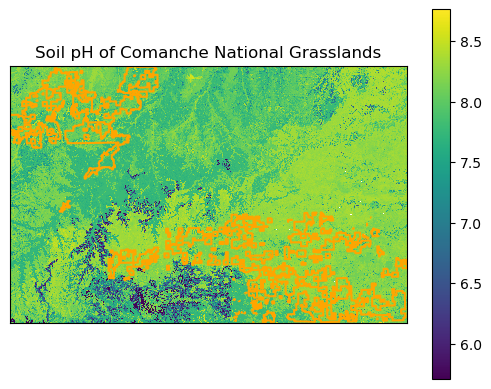

In [172]:
# Quick plot to see pH data of Comanche grassland
comanche_pH_da.plot()
Comanche_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "orange")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("Soil pH of Comanche National Grasslands")
plt.show()

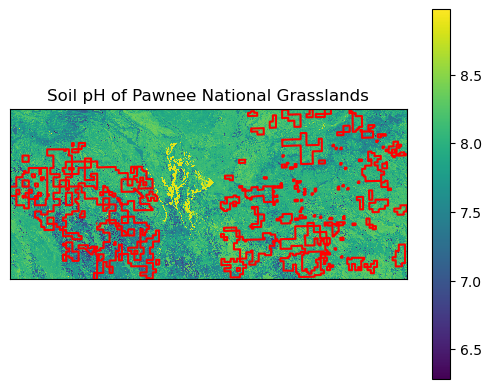

In [171]:
# Quick plot to see pH data of Pawnee grassland
pawnee_pH_da.plot()
Pawnee_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "red")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("Soil pH of Pawnee National Grasslands")
plt.show()

## Downloading Elevation Data

### Data Citation:
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2024-11-20 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003

In [14]:
earthaccess.login()
# Set working directory 
os.makedirs(elevation_dir, exist_ok=True)
srtm_pattern = os.path.join(elevation_dir, '*.hgt.zip')

#Setting bounds for my sites 
bounds = tuple(selectedgrass_gdf.total_bounds)

#Creating buffers around the sites 
buffer = .001
xmin, ymin, xmax, ymax = bounds
bounds_buffer= (xmin-buffer, ymin-buffer, xmax+buffer, ymax+buffer)
#pxmin, pymin, pxmax, pymax = bounds_pawnee
#bounds_buffer_pawnee = (pxmin-buffer, pymin-buffer, pxmax+buffer, pymax+buffer)

#Downloading elevation data
if not glob(srtm_pattern):
    # Selecting elevation data using site bounds
    srtm_results = earthaccess.search_data(
        short_name='SRTMGL1',
        bounding_box= bounds_buffer
    )
    srtm_results = earthaccess.download(srtm_results, elevation_dir)

In [15]:
srtm_da_list=[]
for srtm_path in glob(srtm_pattern):
    #Put files into data array
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale=True).squeeze()
    #Crop data using site boundaries
    cropped_da = tile_da.rio.clip_box(*bounds_buffer)
    srtm_da_list.append(cropped_da)
    

srtm_da = rxrmerge.merge_arrays(srtm_da_list)

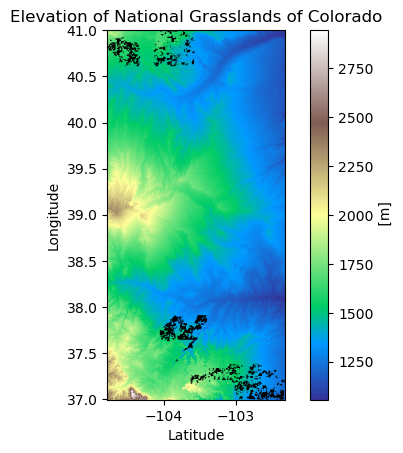

In [16]:
srtm_da.plot(cmap='terrain')
# Plotting my site bounds on top of the elevation data 
selectedgrass_gdf.plot(ax= plt.gca(), color= "black")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Elevation of National Grasslands of Colorado")
plt.show()

## Calculating Slope 

In [17]:
# Clipping and reprojecting the data so units are in meters into my two sites
# Clip elevation files to bounds with buffers for each site
Comanche_utm_gdf = Comanche_gdf.to_crs(utm)
buffer = .001
bounds_comanche = tuple(Comanche_utm_gdf.total_bounds)
cxmin, cymin, cxmax, cymax = bounds_comanche
bounds_buffer_comanche = (cxmin-buffer, cymin-buffer, cxmax+buffer, cymax+buffer)
comanche_elev_da = (srtm_da
                  .rio.reproject(utm)
                  .rio.clip_box(*bounds_buffer_comanche)
)
#Same but now for Pawnee grassland
Pawnee_utm_gdf = Pawnee_gdf.to_crs(utm)
bounds_pawnee = tuple(Pawnee_utm_gdf.total_bounds)
pxmin, pymin, pxmax, pymax = bounds_pawnee
bounds_buffer_pawnee = (pxmin-buffer, pymin-buffer, pxmax+buffer, pymax+buffer)
pawnee_elev_da = (srtm_da
                  .rio.reproject(utm)
                  .rio.clip_box(*bounds_buffer_pawnee)
)

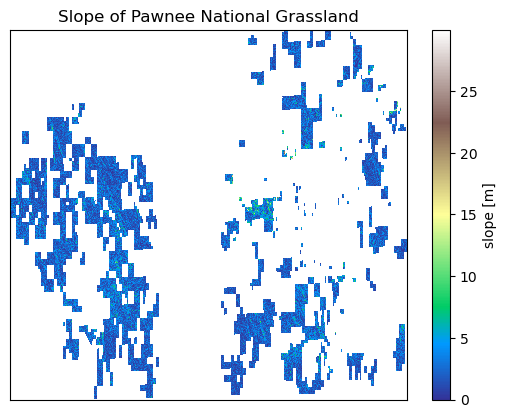

In [18]:
# Checking to see if the clipping worked and plotting slope for Pawnee
pawnee_slope_da = xrspatial.slope(pawnee_elev_da)
pawnee_slope_da_crop = pawnee_slope_da.rio.clip(Pawnee_utm_gdf.geometry)
pawnee_slope_da_crop.plot(cmap='terrain')
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("Slope of Pawnee National Grassland")
plt.show()

Unsurprisingly the Pawnee national grassland is generally quite flat. 

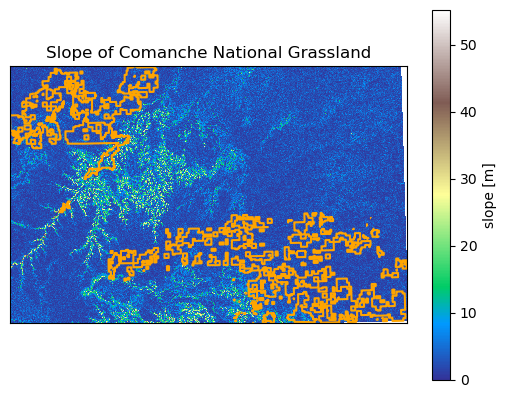

In [19]:
# Plotting Comanche slope
comanche_slope_da = xrspatial.slope(comanche_elev_da)
comanche_slope_da.plot(cmap='terrain')
Comanche_gdf.to_crs(utm).boundary.plot(ax= plt.gca(), color= "orange") 
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("Slope of Comanche National Grassland")
plt.show()

Comanche national grassland is also mostly flat with some elevation gain in the middle of the area.

## Downloading Precipitation Data for RCP 8.5 in 50 and 75 years

### Data Citation: 
Northwest Knowledge Network. (2023). MACAv2 Metdata Precipitation Data - CCSM4 [Data set]. Northwest Knowledge Network. Accessed 2024-12-13 from 
http://thredds.northwestknowledge.net:8080/thredds/catalog/MACAV2/BNU-ESM/catalog.html

In [20]:
os.makedirs(precipitation_dir, exist_ok=True)

precip_path = os.path.join(precipitation_dir, '*.nc')
precip_path

'C:\\Users\\anpo9052\\earth-analytics\\data\\final-project\\precipitation\\*.nc'

In [22]:
# Define function to convert longitude/latitude
def convert_longitude(longitude):
    """Convert longitude range from 0-360 t0 -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

# Downloading precipitation data for 8.5 degree projection 
# For 2096-2099 and 2071-2075

maca_da_list = []
for site_name, site_gdf in {
    'Pawnee National Grassland': Pawnee_gdf,
    'Comanche National Grassland': Comanche_gdf}.items():
    for years in ['2096_2099', '2071_2075']:
        # Define url
        maca_url = (
            'http://thredds.northwestknowledge.net:8080/thredds/dodsC'
            '/MACAV2/CCSM4'
            '/macav2metdata_pr_CCSM4_r6i1p1'
            '_rcp85'
            f'_{years}_CONUS'
            '_monthly.nc') 

        # Open & Squeeze dataset
        maca_da = xr.open_dataset(maca_url).squeeze().precipitation

        # Define bounds
        bounds_maca = (site_gdf
                        .to_crs(maca_da.rio.crs)
                        .total_bounds)

        # Change maca_ds longitude values to match the grasslands gdfs
        maca_da = maca_da.assign_coords(
            lon=("lon", [convert_longitude(l) for l in maca_da.lon.values]))

        # Set spatial dimensions of maca_da
        maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

        # Crop maca_da
        maca_da = maca_da.rio.clip_box(*bounds_maca)
        maca_da_list.append(dict(
            site_name=site_name,
            years=years,
            da=maca_da))

maca_df = pd.DataFrame(maca_da_list)
maca_df

,site_name,years,da
0,Pawnee National Grassland,2096_2099,[[[<xarray.DataArray 'precipitation' ()> Size:...
1,Pawnee National Grassland,2071_2075,[[[<xarray.DataArray 'precipitation' ()> Size:...
2,Comanche National Grassland,2096_2099,[[[<xarray.DataArray 'precipitation' ()> Size:...
3,Comanche National Grassland,2071_2075,[[[<xarray.DataArray 'precipitation' ()> Size:...


In [23]:
def subset_maca_da(df, row, year):
    """
    This function sums MACA climate values across months in each year for a desired data frame row
    and outputs the annual sum for one specified year. 
    
    Parameters
    ----------
    
    df : DataFrame
        The DataFrame the grassland MACA DataArrays are stored in.
    
    row : int
        The row number of the data frame
    
    year: int
        The year for which annual precipitation is extracted
    
    Returns
    -------
    DataArray
        A DataArray of the average total annual precipitation.
    """
    # Subset the data to get one site and one year range
    grassland_years_da = df.loc[row, 'da']

    # Sum the precipitation for all 12 months in each year within the range
    grassland_yearly_precip_da = grassland_years_da.groupby('time.year').sum()

    # Just extract the last year of the dataframe
    grassland_annual_precip_da = grassland_yearly_precip_da.loc[[year]]
    
    # Write the crs and then transform is to utm of 32613
    grass_maca_da = (grassland_annual_precip_da
                            .rio.write_crs(4326)
                            .rio.reproject(utm))
    
    return grass_maca_da

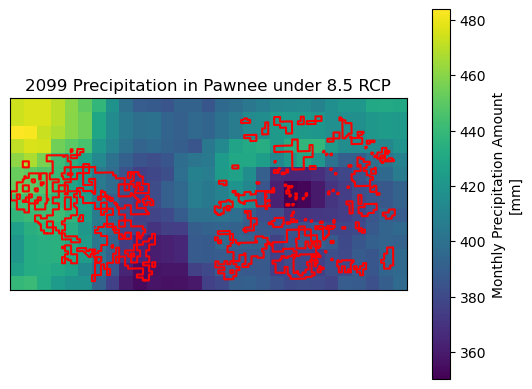

In [35]:
# Getting the annual total precipitaion for Pawnee 2099 and plotting 
Pawnee_precip2099 = subset_maca_da(maca_df, 0, 2099)
Pawnee_precip2099.plot()
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "red") 
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2099 Precipitation in Pawnee under 8.5 RCP")
plt.show()

In [25]:
# Extracting annual precipitation for Pawnee and Comanche in 2074 and 2099 
Pawnee_precip2074 = subset_maca_da(maca_df, 1, 2074)
Comanche_precip2074 = subset_maca_da(maca_df, 3, 2074)
Comanche_precip2099 = subset_maca_da(maca_df, 2, 2099)

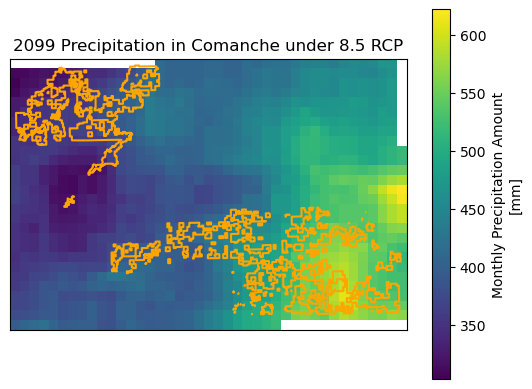

In [38]:
# Plotting total precipitaion for Comanche 2099 
Comanche_precip2099.plot()
Comanche_utm_gdf.boundary.plot(ax= plt.gca(), color= "orange") 
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2099 Precipitation in Comanche under 8.5 RCP")
plt.show()

## Harmonizing the data

In [26]:
# Making sure the grids of each of my data layers match up: 
Pawnee_precip2099_grid = Pawnee_precip2099.rio.reproject_match(pawnee_elev_da)
Pawnee_precip2074_grid = Pawnee_precip2074.rio.reproject_match(pawnee_elev_da)
Comanche_precip2099_grid = Comanche_precip2099.rio.reproject_match(comanche_elev_da)
Comanche_precip2074_grid = Comanche_precip2074.rio.reproject_match(comanche_elev_da)
Pawnee_pH_da_grid = pawnee_pH_da.rio.reproject_match(pawnee_elev_da)
Comanche_pH_da_grid = comanche_pH_da.rio.reproject_match(comanche_elev_da)
Pawnee_slope_da_grid = pawnee_slope_da.rio.reproject_match(pawnee_elev_da)
Comanche_slope_da_grid = comanche_slope_da.rio.reproject_match(comanche_elev_da)

## Logic model 

*Sorghastrum nutans* is currently adapted to the following environmental conditions (Brakie, 2017):

soil pH: 4.8 - 8.0 

elevation: up to 6,800 feet (2072 meters)

precipitation: 280-1140 mm per year

slope: less than 25% for most grasses

The model I use here simply assigns a value of 0 (unsuitable habitat) or 1 (suitable habitat) to each pixel based on the ranges described above for each individual parameter. The rasters are then multiplied across all parameters, and areas where all conditions are met (where all the parameters were equal to 1) are deemed "suitable habitat". This is an overly simple model and in the future could also include tolerance values and incorporate fuzzy Gaussian functions for the parameter ranges. Other assumptions of this model include static soil pH in the future (which may not be the case), and also that *S. nutans* will not adapt its climactic tolerance ranges in the next 50-75 years (natural selection and evolution is a thing!)

## Habitat suitability of Indiangrass in Pawnee National Grassland under 8.5 RCP

### In 50 years (2074) large areas of Pawnee National Grassland will remain suitable for *S. nutans*

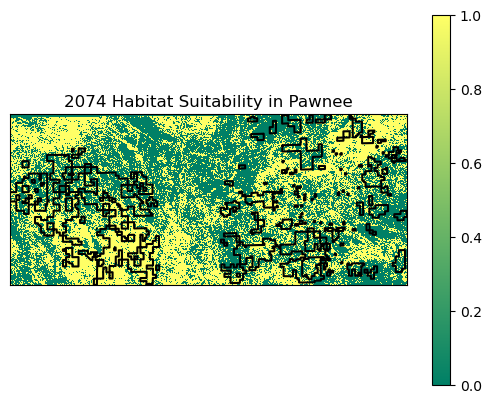

In [30]:
precip_suitable_pawnee_2074 = ((Pawnee_precip2074_grid > 280) * (Pawnee_precip2074_grid < 1140))
elev_suitable_pawnee = pawnee_elev_da < 2072
slope_suitable_pawnee = Pawnee_slope_da_grid < 25
pH_suitable_pawnee = ((Pawnee_pH_da_grid > 4.8) * (Pawnee_pH_da_grid < 8))

pawnee_2074 = precip_suitable_pawnee_2074 * elev_suitable_pawnee * slope_suitable_pawnee * pH_suitable_pawnee
pawnee_2074.plot(cmap='summer')
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2074 Habitat Suitability in Pawnee")
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In this plot the green areas are unsuitable habitat for *S. nutans* while the yellow areas are suitable habitat. The black outlines indicate the boundaries of Pawnee National Grassland. Here we can see, that under the conditions stipulated in the model, many areas of this grassland will remain suitable for the grass in 2074 under RCP 8.5.

In [29]:
pawnee_2074_da_crop = pawnee_2074.rio.clip(Pawnee_utm_gdf.geometry)
suitable_count2074 = np.count_nonzero(pawnee_2074_da_crop)
print(suitable_count2074)

4866859


### In 75 years (2099) *S. nutans* habitat suitability will not change in Pawnee national grassland.

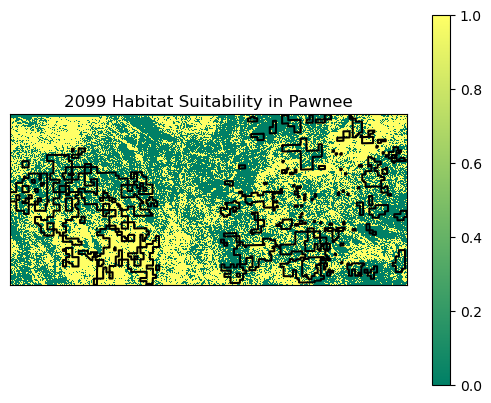

In [31]:
precip_suitable_pawnee_2099 = ((Pawnee_precip2099_grid > 280) * (Pawnee_precip2099_grid < 1140))
elev_suitable_pawnee = pawnee_elev_da < 2072
slope_suitable_pawnee = Pawnee_slope_da_grid < 25
pH_suitable_pawnee = ((Pawnee_pH_da_grid > 4.8) * (Pawnee_pH_da_grid < 8))

pawnee_2099 = precip_suitable_pawnee_2099 * elev_suitable_pawnee * slope_suitable_pawnee * pH_suitable_pawnee
pawnee_2099.plot(cmap="summer")
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2099 Habitat Suitability in Pawnee")
Pawnee_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.show()

In this plot the green areas are unsuitable habitat for *S. nutans* while the yellow areas are suitable habitat. The black outlines indicate the boundaries of Pawnee National Grassland. Here we can see, that under the conditions stipulated in the model, many areas of this grassland will remain suitable for the grass in 2099 under RCP 8.5. In fact the exact same number of pixels within Pawnee will be suitable according to this model in 2074 as in 2099. 

In [32]:
pawnee_2099_da_crop = pawnee_2099.rio.clip(Pawnee_utm_gdf.geometry)
suitable_count2099 = np.count_nonzero(pawnee_2099_da_crop)
print(suitable_count2099)

4866859


## Habitat suitability of Indiangrass in Comanche National Grassland under 8.5 RCP

### In 50 years (2074) only a few areas of Comanche national grassland will be suitable habitat for *S. nutans*

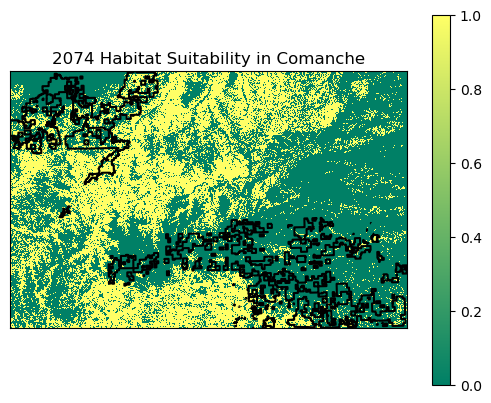

In [33]:
precip_suitable_comanche_2074 = ((Comanche_precip2074_grid > 280) * (Comanche_precip2074_grid < 1140))
elev_suitable_comanche = comanche_elev_da < 2072
slope_suitable_comanche = Comanche_slope_da_grid < 25
pH_suitable_comanche = ((Comanche_pH_da_grid > 4.8) *(Comanche_pH_da_grid < 8))

comanche_2074 = precip_suitable_comanche_2074 * elev_suitable_comanche * slope_suitable_comanche * pH_suitable_comanche
comanche_2074.plot(cmap='summer')
Comanche_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2074 Habitat Suitability in Comanche")
plt.show()

In this plot the green areas are unsuitable habitat for *S. nutans* while the yellow areas are suitable habitat. The black outlines indicate the boundaries of Comanche National Grassland. Here we can see, that under the conditions stipulated in the model, many areas of this grassland will not be suitable for the grass in 2074 under RCP 8.5, as most of the grassland falls in the green areas, with a few northern and southern areas falling in the yellow suitable spots. 

In [143]:
comanche_2074_da_crop = comanche_2074.rio.clip(Comanche_utm_gdf.geometry)
suitable_comanche2074 = np.count_nonzero(comanche_2074_da_crop)
print(suitable_comanche2074)

16885187


### In 75 years (2099) Comanche national grassland will become increasingly suitable for *S. nutans*

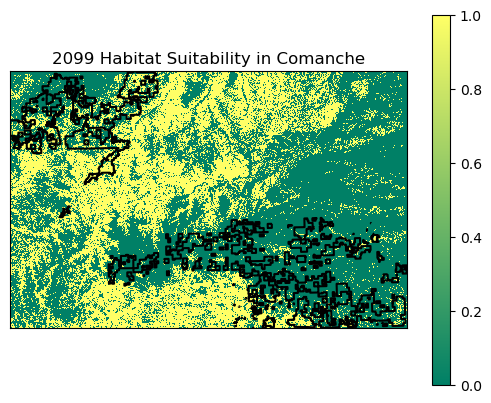

In [34]:
precip_suitable_comanche_2099 = ((Comanche_precip2099_grid > 280) * (Comanche_precip2099_grid < 1140))
elev_suitable_comanche = comanche_elev_da < 2072
slope_suitable_comanche = Comanche_slope_da_grid < 25
pH_suitable_comanche = ((Comanche_pH_da_grid > 4.8) *(Comanche_pH_da_grid < 8))

comanche_2099 = precip_suitable_comanche_2099 * elev_suitable_comanche * slope_suitable_comanche * pH_suitable_comanche
comanche_2099.plot(cmap='summer')
Comanche_utm_gdf.boundary.plot(ax= plt.gca(), color= "black") 
plt.xlabel("")
plt.ylabel("")
plt.xticks([])
plt.yticks([])
plt.title("2099 Habitat Suitability in Comanche")
plt.show()

In this plot the green areas are unsuitable habitat for *S. nutans* while the yellow areas are suitable habitat. The black outlines indicate the boundaries of Comanche National Grassland. Here we can see, that under the conditions stipulated in the model, many areas of this grassland still fall in the green areas, much like in 2074, however more Northern areas will become suitable for the grass as precipitation is projected to increase in those areas under RCP 8.5, potentially allowing *S. nutans* to expand into those regions. Pixel counts within this grassland also indicated that 2099 is projected to have greater habitat suitability for this grass compared to 2074.

In [142]:
comanche_2099_da_crop = comanche_2099.rio.clip(Comanche_utm_gdf.geometry)
suitable_comanche2099 = np.count_nonzero(comanche_2099_da_crop)
print(suitable_comanche2099)

16897730


## Literature Citations

Brakie, M. 2017. Plant Guide for Indiangrass (Sorghastrum nutans). USDA-Natural Resources Conservation Service, East
Texas Plant Materials Center. Nacogdoches, TX 75964.

Forest Service (n.d.). Comanche National Grassland. U.S. Department of Agriculture. Retrieved December 15, 2023 from: https://www.fs.usda.gov/recarea/psicc/recarea/?recid=12409

Forest Service (n.d.). Pawnee National Grassland, NE of Greeley. U.S. Department of Agriculture. Retrieved December 15, 2023 from: https://www.fs.usda.gov/recarea/arp/recarea/?recid=32170

GBIF.org (2024), GBIF Home Page. Available from: https://www.gbif.org [13 January 2020].

Maxwell, D. (2020, March 13). Pawnee National Grassland. Colorado Encyclopedia. Retrieved December 15, 2023 from https://coloradoencyclopedia.org/article/pawnee-national-grassland